Course link:
https://mp.weixin.qq.com/s/AtetdLv8I4tAVYgKSnOfqQ

In [1]:
!pip install backtrader yfinance pandas numpy matplotlib

Looking in indexes: https://mirrors.cloud.tencent.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 1.1 MB/s  0:00:10 eta 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 4.5 MB/s  0:00:01m0:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 1.1 MB/s  0:00:08 eta 0:00:010m
  Preparing metadata (setup.py) ... done
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/81/c4/34e93fe5f5429d7570ec1fa436f1986fb1f00c3e0f43a589fe2bbcd22c3f/pytz-2025.2-py2.py3-none-any.whl (509 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.3 MB/s  0:00:02 eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.4 MB/s  0:00:02 eta 0:00:01
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-

# 1. 初始设置和数据获取

In [6]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 设置matplotlib 样式以获得更好的可视化效果
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)

In [19]:
# 下载比特币（BTC-USD）的历史数据
print("Downloading 2021-01-01 to 2024-01-01 BTC-USD Data...")
data = yf.download("BTC-USD", start="2021-01-01", end="2024-01-01",
                   auto_adjust=False)
data.columns = data.columns.droplevel(0) # 删除多级索引列的第二级
print('Data Downloaded!')
print(data.head())

# 从 pandas DataFrame 创建 Backtrader 数据源
data_feed = bt.feeds.PandasData(dataname=data)

[*********************100%***********************]  1 of 1 completed

Data Downloaded!
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD  \
Date                                                                 
2021-01-01  29374.152344  29374.152344  29600.626953  28803.585938   
2021-01-02  32127.267578  32127.267578  33155.117188  29091.181641   
2021-01-03  32782.023438  32782.023438  34608.558594  32052.316406   
2021-01-04  31971.914062  31971.914062  33440.218750  28722.755859   
2021-01-05  33992.429688  33992.429688  34437.589844  30221.187500   

Ticker           BTC-USD      BTC-USD  
Date                                   
2021-01-01  28994.009766  40730301359  
2021-01-02  29376.455078  67865420765  
2021-01-03  32129.408203  78665235202  
2021-01-04  32810.949219  81163475344  
2021-01-05  31977.041016  67547324782  


# 2. 傅里叶变换策略（FourierStrategy）

In [ ]:
class FourierStrategy(bt.Strategy):
    params = (
        ('lookback', 30),           # FFT 分析的窗口（要考虑的过去柱数）
        ('num_components', 3),      # 用于重构的主导频率分量数量
        ('trend_period', 30),       # 简单移动平均趋势过滤器的周期
        ('stop_loss_pct', 0.02),    # 止损百分比（例如，0.02 = 2%）
    )

    def __init__(self):
        # 存储用于 FFT 分析的收盘价滚动历史
        self.price_history = []
        # 作为长期趋势过滤器的简单移动平均线
        self.trend_ma = bt.indicators.SMA(self.data.close,
                                           period=self.params.trend_period)
        # 存储当前重构的 FFT 信号值及其趋势的变量
        self.fft_signal = 0
        self.fft_trend = 0
        # 跟踪活跃订单以防止多个订单的变量
        self.order = None  # 持有任何活跃买入/卖出订单的引用
        self.stop_order = None  # 持有任何活跃止损订单的引用

    def fourier_analysis(self, prices):
        """
        对给定的价格序列执行 FFT 分析，使用主导频率重构信号，
        并返回当前信号值及其趋势。
        """
        # 确保我们有足够的数据用于回溯期
        if len(prices) < self.params.lookback:
            return 0, 0  # 如果数据不足，返回零

        # 1. 去趋势化数据：去除线性趋势，使数据对 FFT 更加平稳
        x = np.arange(len(prices))  # 为 x 轴（时间索引）创建数组
        coeffs = np.polyfit(x, prices, 1)  # 拟合 1 次多项式（线性趋势）
        trend_line = np.polyval(coeffs, x)  # 计算趋势线值
        detrended_prices = prices - trend_line  # 减去趋势以获得去趋势化数据

        # 2. 应用快速傅里叶变换（FFT）
        fft_values = np.fft.fft(detrended_prices)  # 计算去趋势化数据的 FFT

        # 3. 识别并选择主导频率
        # 计算每个频率分量的幅度（振幅）
        magnitude = np.abs(fft_values)
        # 按幅度排序索引，并选择前 'num_components' 个（不包括索引 0 的 DC 分量）
        # 我们从正频率和负频率中选择前 'num_components' 个，
        # 有效地选择 'num_components' 个主导周期。
        # 确保我们不选择第 0 个（DC）分量
        # 创建一个临时数组，将索引 0 的幅度设置为负无穷以忽略它
        temp_magnitude = magnitude.copy()
        if self.params.num_components > 0:  # 仅当我们实际需要分量时
            temp_magnitude[0] = -np.inf  # 忽略 DC 分量用于周期检测

        dominant_indices = np.argsort(temp_magnitude)[-self.params.num_components:]

        # 4. 仅使用主导频率重构信号
        reconstructed_fft_spectrum = np.zeros_like(fft_values, dtype=complex)  # 用零初始化
        # 仅复制对应于主导频率的 FFT 值
        reconstructed_fft_spectrum[dominant_indices] = fft_values[dominant_indices]

        # 应用逆 FFT 转换回时域
        reconstructed_signal = np.real(np.fft.ifft(reconstructed_fft_spectrum))

        # 5. 提取当前信号值及其方向趋势
        current_signal = reconstructed_signal[-1]  # 重构信号的最后一个值
        # 重构信号的趋势（当前值减去前一个值）
        signal_trend = reconstructed_signal[-1] - reconstructed_signal[-2] if len(reconstructed_signal) > 1 else 0

        return current_signal, signal_trend

    def notify_order(self, order):
        # 每当订单状态改变时，Cerebro 会调用此方法
        if order.status in [order.Completed]:
            # 如果买入订单完成且我们有多头仓位
            if order.isbuy() and self.position.size > 0:
                # 在入场价格下方设置止损订单
                stop_price = order.executed.price * (1 - self.params.stop_loss_pct)
                self.stop_order = self.sell(exectype=bt.Order.Stop, price=stop_price)
                self.log(f'买入执行，价格：{order.executed.price:.2f}，'
                         f'数量：{order.executed.size}，止损设置在：{stop_price:.2f}')
            # 如果卖出订单（用于做空）完成且我们有空头仓位
            elif order.issell() and self.position.size < 0:
                # 在入场价格上方设置止损订单
                stop_price = order.executed.price * (1 + self.params.stop_loss_pct)
                self.stop_order = self.buy(exectype=bt.Order.Stop, price=stop_price)
                self.log(f'卖出执行（做空），价格：{order.executed.price:.2f}，'
                         f'数量：{order.executed.size}，止损设置在：{stop_price:.2f}')

        # 如果订单完成、取消或拒绝，清除订单
        if order.status in [order.Completed, order.Canceled, order.Rejected]:
            self.order = None  # 清除主订单引用
            if order == self.stop_order:  # 如果完成的订单是止损订单
                self.stop_order = None  # 清除止损订单引用

    def log(self, txt, dt=None):
        """策略的日志函数"""
        dt = dt or self.datas[0].datetime.date(0)  # 获取当前日期
        print(f'{dt.isoformat()}，{txt}')

    def next(self):
        # 如果已有待执行的活跃订单，则阻止新订单
        if self.order is not None:
            return

        # 将当前价格存储在历史记录中
        self.price_history.append(self.data.close[0])

        # 仅保留最近的 'lookback' 个价格
        if len(self.price_history) > self.params.lookback:
            self.price_history = self.price_history[-self.params.lookback:]

        # 确保我们有足够的数据进行 FFT 分析
        if len(self.price_history) < self.params.lookback:
            return  # 数据还不够，跳过此柱

        # 对当前价格历史执行傅里叶分析
        signal, signal_trend = self.fourier_analysis(np.array(self.price_history))

        # 更新内部 FFT 信号值以供下一次迭代使用（用于比较 prev_signal）
        prev_signal = self.fft_signal  # 存储前一个信号值
        self.fft_signal = signal  # 用当前信号值更新
        self.fft_trend = signal_trend  # 用当前信号趋势更新

        # 交易逻辑：
        # 多头入场/空头出场：重构信号向上转且当前价格高于趋势 MA
        if (signal_trend > 0 and prev_signal < 0 and
            self.data.close[0] > self.trend_ma[0]):  # 检查当前收盘价是否高于趋势 MA
            if self.position.size < 0:  # 如果当前处于空头仓位
                self.log(f'平空头仓位（FFT 信号向上），价格：{self.data.close[0]:.2f}')
                if self.stop_order is not None:
                    self.cancel(self.stop_order)  # 取消空头的任何活跃止损
                self.order = self.close()  # 平空头仓位
            elif not self.position:  # 如果不在任何仓位
                self.log(f'开多头仓位（FFT 信号向上 & 趋势），价格：{self.data.close[0]:.2f}')
                self.order = self.buy()  # 执行买入订单

        # 空头入场/多头出场：重构信号向下转且当前价格低于趋势 MA
        elif (signal_trend < 0 and prev_signal > 0 and
              self.data.close[0] < self.trend_ma[0]):  # 检查当前收盘价是否低于趋势 MA
            if self.position.size > 0:  # 如果当前处于多头仓位
                self.log(f'平多头仓位（FFT 信号向下），价格：{self.data.close[0]:.2f}')
                if self.stop_order is not None:
                    self.cancel(self.stop_order)  # 取消多头的任何活跃止损
                self.order = self.close()  # 平多头仓位
            elif not self.position:  # 如果不在任何仓位
                self.log(f'开空头仓位（FFT 信号向下 & 趋势），价格：{self.data.close[0]:.2f}')
                self.order = self.sell()  # 执行卖出订单

### Example - Numpy one-dimensional discrete Fourier Transform

In [39]:
np.exp(2j * np.pi * np.arange(8) / 8)
# j represents the imaginery unit in complex numbers

print(f"Real component of (1+2j): {(1+2j).real}, Imaginary component of (1+2j): {(1+2j).imag}")

Real component of (1+2j): 1.0, Imaginary component of (1+2j): 2.0


In [49]:
import numpy as np
temp = np.fft.fft(np.exp(2j * np.pi * np.arange(8) / 8))
print(temp.real) # symmetric
print()
print(temp.imag) # anti-symmetric

[-3.44509285e-16  8.00000000e+00  2.33486982e-16  0.00000000e+00
  9.95799250e-17 -8.88178420e-16  1.14423775e-17  0.00000000e+00]

[ 1.14423775e-17 -9.95431023e-16  1.22464680e-16  1.22464680e-16
  2.33486982e-16  2.60642944e-16  1.22464680e-16  1.22464680e-16]


- The 1D DFT of a length-$N$ sequence $x_n$ is $X_k = \sum_{n=0}^{N-1} x_n\, e^{-i 2\pi kn/N}$ for $k=0,\dots,N-1$, mapping time/space samples to complex frequency bins.
- The inverse DFT reconstructs $x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k\, e^{+i 2\pi kn/N}$, recovering the original sequence when paired with consistent normalization.
- NumPy’s fft/ifft pair uses a normalization convention controlled by norm= "backward" (default), "forward", or "ortho", distributing the $1/N$ factor across forward/backward transforms.

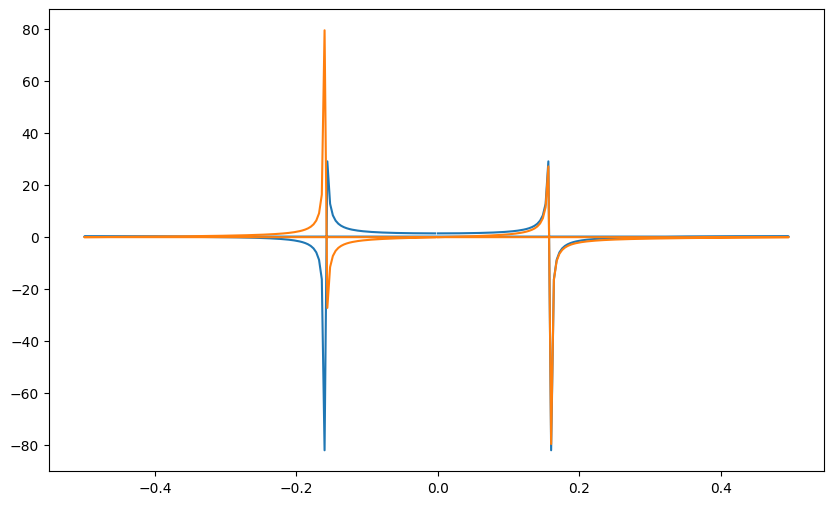

In [ ]:
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
_ = plt.plot(freq, sp.real, freq, sp.imag) # x-y, x-y
plt.show();

### Example - Finished

# 3. 回测设置和执行

In [69]:
# 创建 Cerebro 引擎实例
cerebro = bt.Cerebro()  # 修正拼写错误

# 添加策略
cerebro.addstrategy(FourierStrategy)

# 添加数据源
cerebro.adddata(data_feed)

# 设置仓位大小；每次交易投入可用现金的 95%
cerebro.addsizer(bt.sizers.PercentSizer, percents=95)

# 设置起始现金
cerebro.broker.setcash(100000.0) # 从 $100,000开始

# 设置佣金（例如，每笔交易 0.1%）
cerebro.broker.setcommission(commission=0.001)

# --- 添加分析器以进行全面的性能评估 ---
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')  # 系统质量数

# 打印起始投资组合价值
print(f'起始投资组合价值：${cerebro.broker.getvalue():,.2f}')

# 运行回测
print("正在运行回测...")
results = cerebro.run()
print("回测完成。")

# 打印最终投资组合价值
final_value = cerebro.broker.getvalue()
print(f'最终投资组合价值：${final_value:,.2f}')
print(f'回报率：{((final_value / 100000) - 1) * 100:.2f}%')

# --- 获取并打印分析结果 ---
strat = results[0]  # 从结果中访问策略实例
print("\n--- 策略性能指标 ---")

# 1. 回报分析
returns_analysis = strat.analyzers.returns.get_analysis()
total_return = returns_analysis.get('rtot', 'N/A') * 100
annual_return = returns_analysis.get('rnorm100', 'N/A')
print(f"总回报：{total_return:.2f}%")
print(f"年化回报：{annual_return:.2f}%")

# 2. 夏普比率（风险调整后的回报）
sharpe_ratio = strat.analyzers.sharpe.get_analysis()
sr_value = sharpe_ratio.get('sharperatio', None)
if sr_value is not None:
    print(f"夏普比率：{sr_value:.2f}")
else:
    print("夏普比率：N/A")

# 3. 回撤分析（风险度量）
drawdown_analysis = strat.analyzers.drawdown.get_analysis()
max_drawdown = drawdown_analysis.get('maxdrawdown', 'N/A')
if isinstance(max_drawdown, (int, float)):
    print(f"最大回撤：{max_drawdown:.2f}%")
else:
    print(f"最大回撤：{max_drawdown}%")
print(f"最长回撤持续时间：{drawdown_analysis.get('maxdrawdownperiod', 'N/A')} 柱")

# 4. 交易分析（交易详情）
trade_analysis = strat.analyzers.tradeanalyzer.get_analysis()
total_trades = trade_analysis.get('total', {}).get('total', 0)
won_trades = trade_analysis.get('won', {}).get('total', 0)
lost_trades = trade_analysis.get('lost', {}).get('total', 0)
win_rate = (won_trades / total_trades) * 100 if total_trades > 0 else 0
print(f"总交易次数：{total_trades}")
print(f"盈利交易：{won_trades}({win_rate:.2f}%)")
print(f"亏损交易：{lost_trades}（{100-win_rate:.2f}%）")
avg_win = trade_analysis.get('won', {}).get('pnl', {}).get('average', 'N/A')
if isinstance(avg_win, (int, float)):
    print(f"平均盈利（损益）：{avg_win:.2f}")
else:
    print(f"平均盈利（损益）：{avg_win}")
avg_loss = trade_analysis.get('lost', {}).get('pnl', {}).get('average', 'N/A')
if isinstance(avg_loss, (int, float)):
    print(f"平均亏损（损益）：{avg_loss:.2f}")
else:
    print(f"平均亏损（损益）：{avg_loss}")

# 计算盈利/亏损比率时需确保都为数字且avg_loss不为0
if isinstance(avg_win, (int, float)) and isinstance(avg_loss, (int, float)) and avg_loss != 0:
    print(f"平均盈利/平均亏损比率：{abs(avg_win / avg_loss):.2f}")
else:
    print("平均盈利/平均亏损比率：N/A")


# 5. 系统质量数（SQN）- Dr. Van Tharp 的系统质量度量
sqn_analysis = strat.analyzers.sqn.get_analysis()
print(f"系统质量数（SQN）：{sqn_analysis.get('sqn', 'N/A'):.2f}")

# --- 绘制结果 ---
print("\n正在绘制结果...")
# 调整 matplotlib 绘图参数以防止大数据集警告
plt.rcParams['figure.max_open_warning'] = 0
plt.rcParams['agg.path.chunksize'] = 10000  # 有助于提高大图的性能

try:
    # iplot=False 用于静态图，style='candlestick' 用于蜡烛图
    # plotreturn=True 在单独的子图中显示权益曲线
    # volume=False 删除成交量子图，因为它可能与 FFT 可视化不直接相关
    # fig = cerebro.plot(iplot=False, style='candlestick',
    #                   barup=dict(fill=False, lw=1.0, ls='-', color='green'),  # 自定义看涨蜡烛
    #                   bardown=dict(fill=False, lw=1.0, ls='-', color='red'),  # 自定义看跌蜡烛
    #                   plotreturn=True,  # 显示权益曲线
    #                   numfigs=1,  # 确保只生成一个图形
    #                   volume=False  # 排除成交量图，因为它会使此策略的图表混乱
    #                   )[0][0]  # 访问图形对象以保存/显示
    fig = cerebro.plot(
        iplot=False,
        style='candlestick',
        barup='green',
        bardown='red',
        plotreturn=True,
        numfigs=1,
        volume=False
    )[0][0]

    plt.show()  # 显示图表
except Exception as e:
    print(f"绘图错误：{e}")
    print("策略成功完成，但由于错误跳过了绘图。")


起始投资组合价值：$100,000.00
正在运行回测...
回测完成。
最终投资组合价值：$100,000.00
回报率：0.00%

--- 策略性能指标 ---
总回报：0.00%
年化回报：0.00%
夏普比率：N/A
最大回撤：N/A%
最长回撤持续时间：N/A 柱
总交易次数：0
盈利交易：0(0.00%)
亏损交易：0（100.00%）
平均盈利（损益）：N/A
平均亏损（损益）：N/A
平均盈利/平均亏损比率：N/A
系统质量数（SQN）：0.00

正在绘制结果...


In [71]:
plt.show();